# 🐶 End-to-end Multil-class Dog Breed Classification
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.x and TensorFlow Hub.

1. Problem
Identifying the breed of a dog given an image of a dog.
When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

2. Data
The data we're using is from Kaggle's dog breed identification competition.
https://www.kaggle.com/c/dog-breed-identification/data

3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

4. Features
Some information about the data:

We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
There are 120 breeds of dogs (this means there are 120 different classes).
There are around 10,000+ images in the training set (these images have labels).
There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

In [ ]:
# unzip the uploaded data into google drive
# !unzip 'drive/MyDrive/Dog Vision/dog-breed-identification.zip' -d 'drive/MyDrive/Dog Vision/'

### Get our workspace ready

* import tensorflow 2.0
* make sure you are using GPU

In [ ]:
# import tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub
print('tf version: ', tf.__version__)
print('tf_hub version: ', hub.__version__)

# check GPU avalibility
print('GPU', 'available (YESSSSSSS!!!!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

tf version:  2.12.0
tf_hub version:  0.13.0
GPU available (YESSSSSSS!!!!)


### GPU vs TPU

GPUs are suitable for tasks that require high computation power and have a large number of parameters, such as training deep neural networks. GPUs are also beneficial for smaller datasets that can be loaded into the memory of the GPU.

TPUs, on the other hand, are optimized for tasks that require high-speed matrix multiplications, such as training large-scale neural networks. TPUs are particularly beneficial for tasks that involve large amounts of data and have a large number of parameters.

## getting data ready(turning into tensors)
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [ ]:
# chkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv('drive/MyDrive/Dog Vision/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# how many images of each breed?
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

<Axes: >

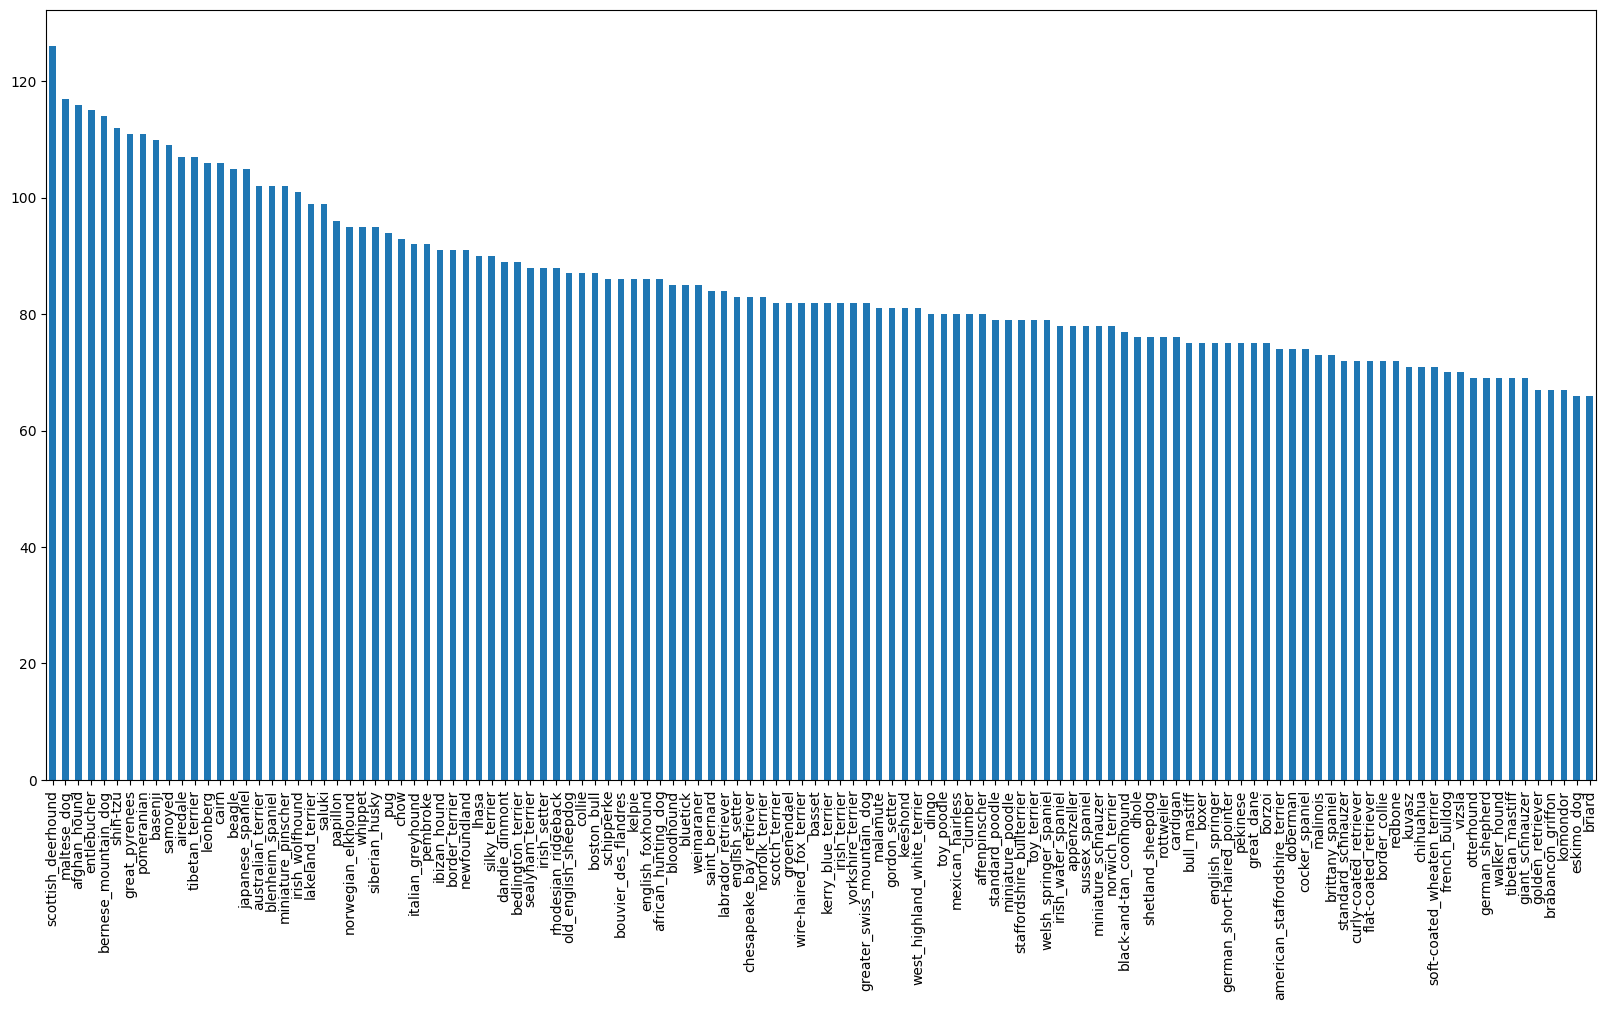

In [ ]:
labels_csv['breed'].value_counts().plot.bar(figsize= (20,10))

In [ ]:
labels_csv['breed'].value_counts().median()

82.0

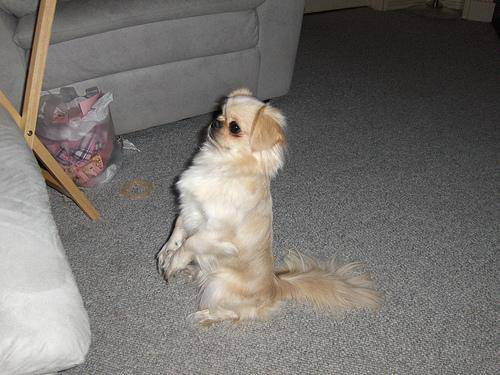

In [ ]:
# let's view an image
import IPython
from IPython.display import Image
Image('drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg')

In [ ]:
 pip install ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 225. Preparing The Images

### getting images and their labels

# let's get list of all of our images

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# cerate pathnames from image ID's
filenames = ['drive/MyDrive/Dog Vision/train/' + fname + '.jpg' for fname in labels_csv['id']]

# chk the first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# chk weather number of filnames matches number of actual image files
import os
if len(os.listdir('drive/MyDrive/Dog Vision/train/')) == len(filenames):
  print('filename match actual amount of files')
else:
  print('filenames do not match')

filename match actual amount of files


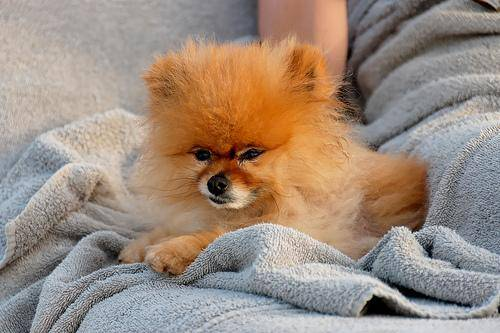

In [ ]:
# one more chk
Image(filenames[8000])

In [ ]:
labels_csv['breed'][8000]

'pomeranian'

  # 226. Turning Data Labels Into Numbers

In [ ]:
import numpy as np
labels = labels_csv['breed']
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# chk if no. of labels matches number of filenames
if len(labels) == len(filenames):
  print('labels and filenames matches')
else:
  print('labels and filenames do not match')

labels and filenames matches


In [ ]:
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds 

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# turn every label into booleans
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
# example: turn boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be 1 where sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# 227. Creating Our Own Validation Set

### creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.



In [ ]:
# setup x&y variables
x = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

We're going to start off experimenting with ~1000 images and increase as needed.

In [ ]:
# set number of images to be used for experimenting
NUM_IMAGES = 1000 #@param {type: 'slider', min: 1000, max: 10000, step: 1000}

In [ ]:
# let's split our data into train and validation set
from sklearn.model_selection import train_test_split

# split them into training and validation of total size NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(x[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size = 0.2,
                                                  random_state = 89)

len(x_train), len(x_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [ ]:
# let's have a look at data
x_train[:2], y_train[:2]

(['drive/MyDrive/Dog Vision/train/0d0d0f7c689020c35b83a91e7717624b.jpg',
  'drive/MyDrive/Dog Vision/train/0e756365807ec27c6dfd944ba5b442b3.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False,  True, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

  # 228. Preprocess Images

# turning iamges into tensors
to preprocess our images into tensors we are going to write a function which does a few things:
1. take image filpath as input
2. use tensorflow to read and save it to a variable
3. turn the .jpg image into tensors
4. resize the image to shape (224, 224)
5. return the modified image

before we do let's see what an importing image looks like

In [ ]:
# convert image to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[78])
image.shape

(500, 500, 3)

In [ ]:
image.min(), image.max(), image

(0,
 255,
 array([[[170, 160, 150],
         [170, 160, 150],
         [170, 160, 150],
         ...,
         [173, 159, 150],
         [173, 159, 150],
         [173, 159, 150]],
 
        [[170, 160, 150],
         [170, 160, 150],
         [170, 160, 150],
         ...,
         [173, 159, 150],
         [173, 159, 150],
         [173, 159, 150]],
 
        [[170, 160, 150],
         [170, 160, 150],
         [170, 160, 150],
         ...,
         [174, 160, 151],
         [174, 160, 151],
         [174, 160, 151]],
 
        ...,
 
        [[196, 188, 177],
         [195, 187, 176],
         [195, 187, 176],
         ...,
         [182, 172, 162],
         [182, 172, 162],
         [182, 172, 162]],
 
        [[196, 188, 177],
         [195, 187, 176],
         [195, 187, 176],
         ...,
         [182, 172, 162],
         [182, 172, 162],
         [182, 172, 162]],
 
        [[196, 188, 177],
         [195, 187, 176],
         [195, 187, 176],
         ...,
         [182, 172

In [ ]:
# turn image into tensor
tf.constant(image[:2])  

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[170, 160, 150],
        [170, 160, 150],
        [170, 160, 150],
        ...,
        [173, 159, 150],
        [173, 159, 150],
        [173, 159, 150]],

       [[170, 160, 150],
        [170, 160, 150],
        [170, 160, 150],
        ...,
        [173, 159, 150],
        [173, 159, 150],
        [173, 159, 150]]], dtype=uint8)>

# 229. Preprocess Images 2

let's create an function to preprocess image in tensors
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the image to be a shape of (224, 224)
6. Return the modified image


In [ ]:
# define image size
IMG_SIZE = 224

# create a func for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  '''
  takes the image file path and turn it into tensor.
  '''
  # read in an image file
  image = tf.io.read_file(image_path) # (converts the image into encoded-strings)
  # turn the .jpeg image into tensors with 3 color channels(RGB)
  image = tf.image.decode_jpeg(image, channels = 3)  # (decodes the encoded-string image into tensors)
  # convert the color channel from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # resize the image to ous desired value(224, 224)
  image = tf.image.resize(image, size = [img_size, img_size])

  return image

In [ ]:
# example for above
tensor_string = tf.io.read_file(filenames[90])
tensor_string

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [ ]:
# example for above
tensor_decode = tf.image.decode_jpeg(tensor_string, channels = 3)
tensor_decode

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[ 91, 169, 207],
        [ 94, 172, 210],
        [ 96, 174, 212],
        ...,
        [167, 130,  50],
        [172, 135,  55],
        [170, 133,  53]],

       [[ 89, 167, 205],
        [ 91, 169, 207],
        [ 92, 170, 208],
        ...,
        [168, 131,  51],
        [171, 132,  53],
        [164, 127,  47]],

       [[ 87, 165, 203],
        [ 88, 166, 204],
        [ 88, 166, 204],
        ...,
        [171, 132,  53],
        [169, 128,  49],
        [158, 119,  40]],

       ...,

       [[131, 149, 127],
        [136, 154, 132],
        [139, 156, 137],
        ...,
        [104,  75,  31],
        [103,  74,  30],
        [102,  73,  29]],

       [[132, 150, 128],
        [136, 154, 132],
        [137, 154, 135],
        ...,
        [103,  74,  30],
        [102,  73,  29],
        [101,  72,  28]],

       [[134, 152, 130],
        [132, 150, 128],
        [129, 146, 127],
        ...,
        [103,  74,  3

In [ ]:
# example for above
tf.image.convert_image_dtype(tensor_decode, tf.float32)  

<tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[0.35686275, 0.6627451 , 0.8117648 ],
        [0.36862746, 0.6745098 , 0.8235295 ],
        [0.37647063, 0.68235296, 0.8313726 ],
        ...,
        [0.654902  , 0.50980395, 0.19607845],
        [0.6745098 , 0.5294118 , 0.21568629],
        [0.6666667 , 0.52156866, 0.20784315]],

       [[0.34901962, 0.654902  , 0.80392164],
        [0.35686275, 0.6627451 , 0.8117648 ],
        [0.36078432, 0.6666667 , 0.81568635],
        ...,
        [0.65882355, 0.5137255 , 0.20000002],
        [0.67058825, 0.5176471 , 0.20784315],
        [0.6431373 , 0.49803925, 0.18431373]],

       [[0.34117648, 0.64705884, 0.7960785 ],
        [0.34509805, 0.6509804 , 0.8000001 ],
        [0.34509805, 0.6509804 , 0.8000001 ],
        ...,
        [0.67058825, 0.5176471 , 0.20784315],
        [0.6627451 , 0.5019608 , 0.19215688],
        [0.61960787, 0.4666667 , 0.15686275]],

       ...,

       [[0.5137255 , 0.58431375, 0.49803925],
        [0.53

  ## turning our data into batches

  why turn our data into batches?
  -->let's say we are trying to process 10000+ images into one go... they all might not fit into memory.
     so that's why we distribute data into batches(here 32) at a time(you can adjust size if you want to)

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (image, label).

In [ ]:
# create a simple function to return a tuple(image, tuple)
def get_image_label(image_path, label):
  '''
  takes an image file path and the associated label,
  processes the image and returns a type of (image, label).
  '''
  image = process_image(image_path)
  return image, label

In [ ]:
# demo of above
process_image(x[34]), tf.constant(y[34])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.09042301, 0.10218772, 0.12179556],
         [0.11473363, 0.12649834, 0.14610618],
         [0.09272581, 0.10449051, 0.12409835],
         ...,
         [0.8196079 , 0.79215693, 0.7294118 ],
         [0.8136382 , 0.78618723, 0.7234421 ],
         [0.80392164, 0.77647066, 0.7137255 ]],
 
        [[0.08168886, 0.09737513, 0.10913984],
         [0.09317888, 0.10886515, 0.12062985],
         [0.1127224 , 0.12840867, 0.14017338],
         ...,
         [0.8196079 , 0.79215693, 0.7294118 ],
         [0.8136382 , 0.78618723, 0.7234421 ],
         [0.80480576, 0.7773548 , 0.7146096 ]],
 
        [[0.1778584 , 0.19354467, 0.20530938],
         [0.10785257, 0.12353884, 0.13530354],
         [0.17694902, 0.1926353 , 0.2044    ],
         ...,
         [0.8196079 , 0.79215693, 0.7294118 ],
         [0.8136382 , 0.78618723, 0.7234421 ],
         [0.8078432 , 0.7803922 , 0.7176471 ]],
 
        ...,
 
        [[0.14830667, 0.16399294

# 231. Turning Data Into Batches 2

we have convertd our data into tensors in form(image, label), let's make func to tuen all our data into batches.

In [ ]:
# define the batch size, 32 is good start
BATCH_SIZE = 32

# create a func to tuen data into batches
def create_data_batches(x, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  '''
  creates batches of data out of image(x) and label(y) pairs.
  shuffles the data if it's training data and doesn't if it's validation data.
  also accepts test data as input(no labels).
  '''
  # if the data is a test dataset, we probably don't have labels
  if test_data:
    print('creating test data batches')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths(no labels)
    data_batch = data.map(process_image).batch(batch_size)  # here only image(x) are used and not label(y)
    return data_batch

  # * if the data is valid dataset, we don't need to shuffle it
  # * The reason we don’t shuffle data for validation dataset is that we want to evaluate our model’s performance
  #   on data that it hasn’t seen before. If we shuffle the validation data, then it’s possible that our model will
  #   see some of the same examples during training and validation, which could lead to overfitting.
  elif valid_data:
    print('creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),  # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(batch_size)  # use get_image_label as here label(y) are also included along with image(x)
    return data_batch
  
  else:
    print('creating training data batches')

    # turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
    
    # shuffling images and labels before mapping image processor makes func faster as compared to after processing
    data = data.shuffle(buffer_size = len(x)) # shuffles data 'x' times

    # create (image, labels) tuples(this also turns the image into a preprocessed image)
    data = data.map(get_image_label)

    # turn the training data into batches
    data_batch = data.batch(batch_size)

  return data_batch

In [ ]:
# create training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data = True)

creating training data batches
creating validation data batches...


In [ ]:
# chk out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

# 232. Visualizing Our Data

our data is in batches, however this can be little hard to visualize!

In [ ]:
import matplotlib.pyplot as plt

# cretae a func for viewing images in data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # setup fig
  plt.figure(figsize = (10, 10))
  # loop through 25 (for displaying 25 images)
  for i in range(25):
    # create subplots(5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # display an image
    plt.imshow(images[i])
    # add an image label as title
    plt.title(unique_breeds[labels[i].argmax()])
    # turn grid lines off
    plt.axis('off')  # to remove the axis values

In [ ]:
# example for above
unique_breeds[y[10].argmax()]

'shetland_sheepdog'

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.6508195 , 0.60376066, 0.5017999 ],
          [0.65445423, 0.6073954 , 0.50543463],
          [0.6590606 , 0.6120018 , 0.510041  ],
          ...,
          [0.4987677 , 0.66135263, 0.54184043],
          [0.45380792, 0.5655287 , 0.3967234 ],
          [0.4583596 , 0.55344886, 0.37298667]],
 
         [[0.658936  , 0.6118772 , 0.5099164 ],
          [0.6578169 , 0.61075807, 0.5087973 ],
          [0.65590864, 0.6088498 , 0.50688905],
          ...,
          [0.4249697 , 0.56745565, 0.44740775],
          [0.42105627, 0.533697  , 0.4139634 ],
          [0.42022058, 0.52117467, 0.40220588]],
 
         [[0.6670263 , 0.61996746, 0.5180067 ],
          [0.6628873 , 0.61582845, 0.5138677 ],
          [0.6557633 , 0.6087045 , 0.5067437 ],
          ...,
          [0.47304487, 0.5549196 , 0.445718  ],
          [0.49322927, 0.56488097, 0.4949973 ],
          [0.47956055, 0.5594537 , 0.4944853 ]],
 
         ...,
 
         [[0.44607323, 0.2045803 , 0.03104223],
          [0.29736

In [ ]:
len(train_images), len(train_labels)

(32, 32)

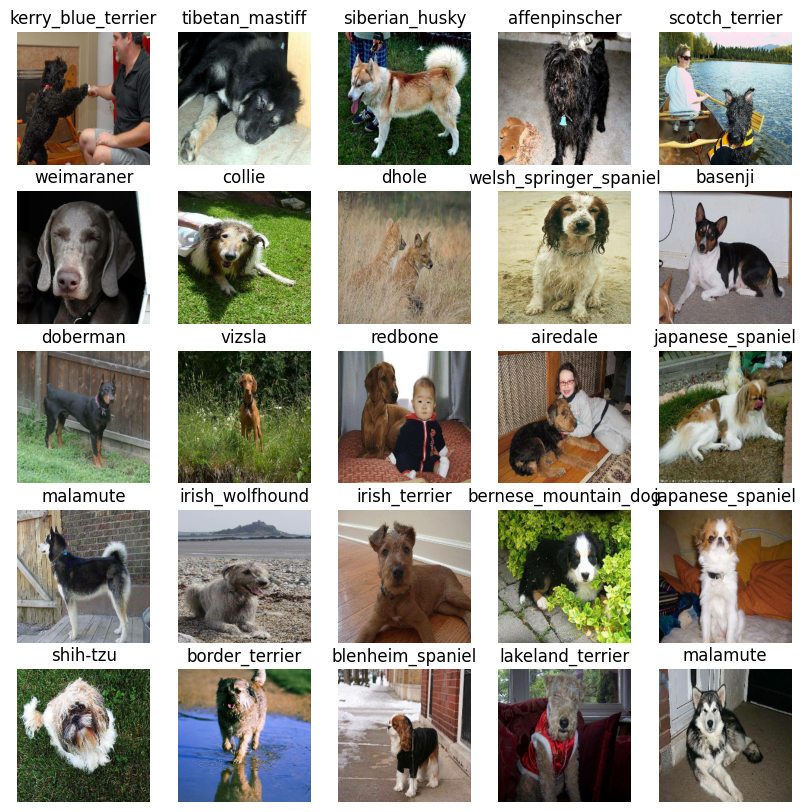

In [ ]:
# now let's visualize the data
show_25_images(train_images, train_labels)

In [ ]:
  # now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# 233. Preparing Our Inputs and Outputs

# building a model
Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [ ]:
# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# setup model URL from tensorflow hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'

# 236. Building A Deep Learning Model 2

## sequential VS functional
* The Sequential API allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.
* On the other hand, the Functional API is more flexible than the Sequential API. It allows for branching or sharing of layers and can have multiple inputs and outputs 

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.


All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# create a function that builds a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print('Building model with: ', MODEL_URL)

  # setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),    # layer 1(input layer)
      tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                            activation = 'softmax'),  # layer 2(output layer)
  ])

  # compile model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ['accuracy']
  )

  # build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

# 240. Evaluating Our Model

## creating callbacks
callbacks are the helper funcs. a model can use during training to do such things as save its progress, chk its progress or stop training early if a model stops improving. 

we'll create two callbacks, one for TensorBoard which helps track our models progress and another ofr early stopping which prebents our model from over-training.

## TensorBoard callback

To setup a TensorBoard callback, we need to do 3 things:

1. Load the TensorBoard notebook extension 
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function. 
3. Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [ ]:
# load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# craete a func to build a TensorBoard callback
def create_tensorboard_callback():
  # create a log directory for storing TensorBoard logs
  logdir = os.path.join('drive/MyDrive/Dog Vision/logs',
                        # make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime('%d%m%y - %H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

# 241. Preventing Overfitting

### early stopping callbacks

early stopping helps stop our model from overfitiing by stopping training if a certain evaluation metric stops imporoving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# create early stoppinh callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                  patience = 3)

# 242. Training Your Deep Neural Network

### tarining our model (on subset of data)
our first model is going to train on 1000 images, to make sure everything is working.

In [ ]:
# epochs = number of times our model goes through the data to find patterns

NUM_EPOCHS = 100 #@param {type:'slider', min:10, max:100, step:10}

In [ ]:
# chk the availability of GPU
print('GPU available(YESSSSS!!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

In [ ]:
# build a func to train and return the trained model
def train_model():
  '''
  trains a given model and returns the trained version
  '''
  # create a model
  model = create_model()

  # craetes a new TensorBoard session(folder in drive) every time we train the model
  tensorboard = create_tensorboard_callback()

  # fit the data to the model passing it the callbacks created
  model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [tensorboard, early_stopping])
  # return the fitted model
  return model

In [ ]:
# fit the data to model
model = train_model()

**Question**: It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note**: Overfitting to begin with is a good thing! It means our model is learning!!!

**solution**
1. Early Stopping
2. Train with more data
3. Feature Selection
4. Cross-Validation
5. Data Augmentation
6. Regularization

# 242. Training Your Deep Neural Network

### chking the TensorBoard logs
the TensorBoard magic func(%tensorboard) will access the logs directly we created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

# 244. Make And Transform Predictions

making and evaluating predictions using a trained model

In [ ]:
val_data

In [ ]:
# make predictions on validation data(not used to train on till now)
predictions = model.predict(val_data, verbose = 1)
predictions

In [ ]:
predictions.shape

In [ ]:
predictions[0]

In [ ]:
np.sum(predictions[0]) # will be close to 1 as softmax function distribute in (0, 1)

In [ ]:
len(y_val)

In [ ]:
len(unique_breeds)

In [ ]:
# first prediction
index = 0
print(predictions[0])
print(f'Max value (probablity of prediction): {np.max(predictions[index])}')
print(f'sum: {np.sum(predictions[index])}')
print(f'Max index: {np.argmax(predictions[index])}')
print(f'predicted label: {unique_breeds[np.argmax(predictions[index])]}')

In [ ]:
unique_breeds[7]

# 245. Transform Predictions To Text

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note**: Prediction probabilities are also known as confidence levels.

In [ ]:
# turn prediction probablility into their repective label(easier to understand)
def get_pred_label(prediction_probabilities):
  '''
  turns an array of prediction probabilities into a label
  '''
  return unique_breeds[np.argmax(prediction_probabilities)]

In [ ]:
# get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[56])
pred_label

### now since our data is in batch dataset, we need to unbatchify it to amke predictions on the validation images and then compare those predictions to the validation labels(tryth labels)

In [ ]:
val_data

In [ ]:

images_ = []
labels_ = []

# loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

images_[0], labels_[0]

In [ ]:
# craete a function to unbatch a batch dataset
def unbatchify(data):
  '''
  takes a batch dataeset of(image, label) tensors and returns seperate arrays of images and labels.
  '''
  images = []
  labels = []

  # loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

# 246. Visualizing Model Predictions

Now we've got ways to get get:

* Prediction labels
* Validation labels (truth labels)
* Validation images
Let's make some function to make these all a bit more visaulize.

We'll create a function which:

* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. 
* Convert the prediction probabilities to a predicted label. 
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. 

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n = 1):
  '''
  view the prediction, grd truth and image for sample n
  '''
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # get the pred_label
  pred_label = get_pred_label(pred_prob)

  # plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # change the colour of the title depending on the prediction is right or wrong
  if pred_label == true_label:
    color = 'green'
  else:
    color = 'red'

  # change plot title to be predicted, probablity of prediction and truth label
  plt.title('{} {:2.0f}% {}'.format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color = color)

In [ ]:
plot_pred(prediction_probabilities = predictions,
          labels = val_labels,
          images = val_images)

In [ ]:
plot_pred(prediction_probabilities = predictions,
          labels = val_labels,
          images = val_images,
          n = 67)

# 247. Visualizing And Evaluate Model Predictions 2

now we have got to visualize our models top predictions, let's make another function to view top 10 predictions

this func will:
* take the input of predicitions probab array and grd truth array and an integer array
* find the prediction using 'get_pred_label()'
* find the top 10:
  * prediction probab indexes
  * prediction probab values
  * prediction labels:
* plot the top 10 prediction probab values and labels, coloring the true label green

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  '''
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  '''
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # get the predicted label
  pred_label = get_pred_label(pred_prob)

  # find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # finding top 10 predicted values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # finding top 10 predicted labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = 'brown')
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = 'vertical')
  
  # change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass

In [ ]:
unique_breeds[predictions[0].argsort()[-10:][::-1]]

In [ ]:
predictions[0]

In [ ]:
predictions[0][predictions[0].argsort()[-10:][::-1]]

In [ ]:
predictions[0].max()

In [ ]:
unique_breeds[predictions[0].argsort()[-10:][::-1]]

In [ ]:
plot_pred_conf(prediction_probabilities = predictions,
               labels = val_labels,
               n = 5)

# 248. Visualizing And Evaluate Model Predictions 3

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.



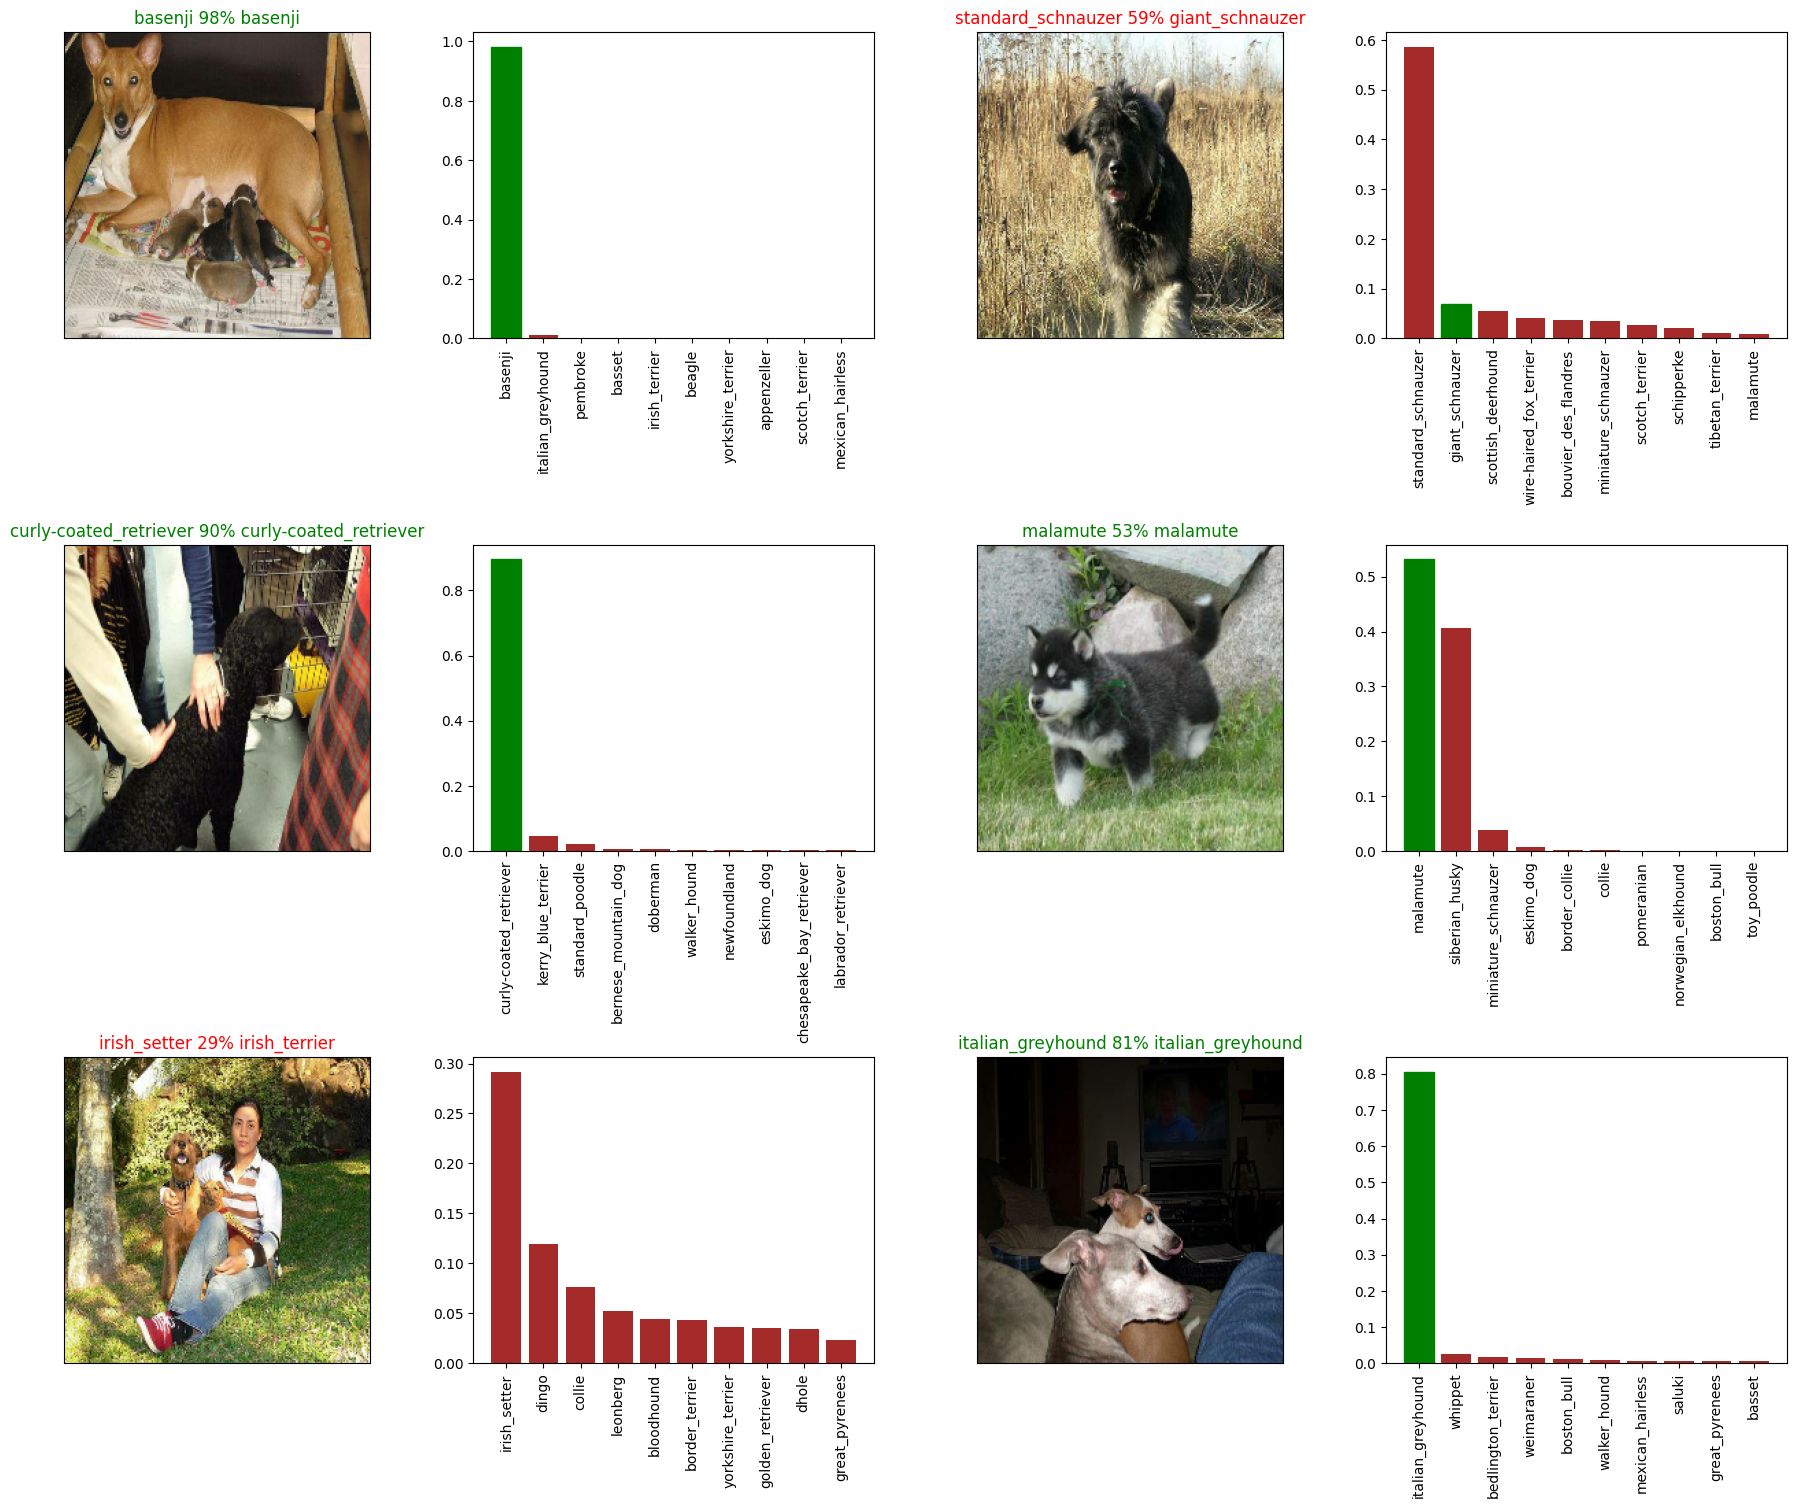

In [ ]:
# let's chk out some predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols

plt.figure(figsize = (9*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities = predictions,
            labels = val_labels,
            images = val_images,
            n = i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities = predictions,
                 labels = val_labels,
                 n = i+i_multiplier)
  
plt.tight_layout(h_pad = 1.0)
plt.show()

# 249. Saving And Loading A Trained Model

In [ ]:
# create a func to save a model
def save_model(model, suffix=None):
  '''
  saves a given model in a models directory and appends a suffix(string).
  '''
  # create a model directory pathname with current time
  modeldir = os.path.join('drive/MyDrive/Dog Vision/models',
                          datetime.datetime.now().strftime('%y%m%d-%H%M%s'))
  model_path = modeldir + '-' + suffix +'.h5'    # (.h5 is save format of model)
  print(f'saving model to: {model_path}...')
  model.save(model_path)

  return model_path

In [ ]:
# craete a func to load a model
def load_model(model_path):
  '''
  loads a saved model from a specified path
  '''
  print(f'loading saved model from: {model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {'KerasLayer':hub.KerasLayer})
  return model

we have save and load models, now let's run them

In [ ]:
# save our model trained on 1000 images
save_model(model, suffix = '1000-images-mobilenetv2-Adam')

saving model to: drive/MyDrive/Dog Vision/models/230401-16501680367847-1000-images-mobilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/models/230401-16501680367847-1000-images-mobilenetv2-Adam.h5'

In [ ]:
# load a trianed model
loaded_1000_image_model = load_model('drive/MyDrive/Dog Vision/models/230331-17231680283422-1000-images-mobilenetv2-Adam.h5')

loading saved model from: drive/MyDrive/Dog Vision/models/230331-17231680283422-1000-images-mobilenetv2-Adam.h5


In [ ]:
# evaluate the saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 75ms/step - loss: 1.0806 - accuracy: 0.6900


[1.0806375741958618, 0.6899999976158142]

In [ ]:
# evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

# 250. Training Model On Full Dataset

# training a big dog model (on full data)


In [ ]:
len(x), len(y)

In [ ]:
x[:10]

In [ ]:
x_train[:10], len(x_train)

In [ ]:
y[:2]

In [ ]:
# create a data batch with the full data set
full_data = create_data_batches(x, y)

In [ ]:
full_data

In [ ]:
# create a model for full model
full_model = create_model()

In [ ]:
# create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

# no validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',
                                                             patience = 3) 

Note: Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [ ]:
# fit the full model to full data
full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

In [ ]:
len(x)

In [ ]:
save_model(full_model, suffix = 'full-image-set-mobilenetv2-Adam')

In [ ]:
# loading the full model
loaded_full_model = load_model('drive/MyDrive/Dog Vision/models/230401-12451680353128-full-image-set-mobilenetv2-Adam.h5')

  # 251. Making Predictions On Test Images

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created create_data_batches() earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames.
* Convert the filenames into test data batches using create_data_batches() and setting the test_data parameter to True (since the test data doesn't have labels).
* Make a predictions array by passing the test batches to the predict() method called on our model.

In [ ]:
# load test image filename
test_path = 'drive/MyDrive/Dog Vision/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

In [ ]:
len(test_filenames)

In [ ]:
# create test data batch
test_data = create_data_batches(test_filenames, test_data = True)

In [ ]:
test_data

calling predict() on our full model and passing it the test batch will take a long time to run (1 hr)

In [ ]:
# make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose = 1)

In [ ]:
# save predictions(NumPy array) to .csv file (for access later)
np.savetxt('drive/MyDrive/Dog Vision/preds_array.csv', test_predictions, delimiter = ',')

In [ ]:
# load predictions(NumPy array) from .csv file
test_predictions = np.loadtxt('drive/MyDrive/Dog Vision/preds_array.csv', delimiter = ',')

# 252. Submitting Model to Kaggle

# preparing test dataset predictions for kaggle
Looking at the Kaggle sample submission, we find that it wants our models prediction probaiblity outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:

* create a pandas DataFrame with an ID column as well as a column for each dog breed.
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a csv to submit it to kaggle.

In [ ]:
['id'] + list(unique_breeds)

In [ ]:
# create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns = ['id'] + list(unique_breeds))
preds_df.head()

In [ ]:
# append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_ids

In [ ]:
preds_df.head()

In [ ]:
# add the prediction probabilities to each dao breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
preds_df.to_csv('drive/MyDrive/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv',
                index = False)

# 253. Making Predictions On Our Images

to make predictions on custom images, we'll:

* get the filepaths of our own images.
* turn the filepaths into data batches using create_data_batches(). and since our custom images test_data parameter to True.
* pass the custom image data batch to our model's predict() method.
* convert the prediction output probabilities to predictions labels.
* compare the predicted labels to the custom images.

In [ ]:
# get the custom image filepaths
custom_path = 'drive/MyDrive/Dog Vision/my-dog-photos/'
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [ ]:
custom_image_paths

In [ ]:
# turn custom images into datasets
custom_data = create_data_batches(custom_image_paths, test_data = True)
custom_data

In [ ]:
# make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [ ]:
custom_preds.shape

In [ ]:
# get custom image prediciton labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [ ]:
# get custom images(our unbatchify() func won't work since there aren't labels.....)
custom_images = []
# loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [ ]:
# chk custom image predictions
plt.figure(figsize = (10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)